# Predicción de la demanda de alquiler de bicicletas

El objetivo de este proyecto es desarrollar un modelo de Machine Learning para la predicción de la demanda de alquiler de bicicletas, utilizando el *Bike Sharing Dataset*. La gestión eficiente de sistemas de bicicletas compartidas depende de la capacidad de anticipar la demanda de los usuarios, lo cual permite planificar la distribución de bicicletas, optimizar recursos y mejorar el servicio.

El *Bike Sharing Dataset* es un conjunto de datos de referencia en la comunidad de aprendizaje automático y análisis predictivo. Contiene información horaria de alquileres de bicicletas entre 2011 y 2012 en Washington D.C., junto con variables relacionadas con el clima, las estaciones del año, los días de la semana y las horas del día. Esto lo convierte en un recurso idóneo para comparar modelos y técnicas de predicción en un contexto real.

Este proyecto se enmarca en una tarea de regresión supervisada, en la cual el modelo debe aprender a predecir el número de bicicletas alquiladas por hora a partir de variables temporales y meteorológicas. Además, se han implementado técnicas de preprocesamiento e ingeniería de características para mejorar la calidad de los datos y la capacidad predictiva de los modelos.

El flujo de trabajo seguido en este proyecto ha sido el siguiente:

- **Tratamiento y Preprocesamiento de los Datos:** limpieza, transformación y creación de nuevas variables (cíclicas, meteorológicas y de contexto) para mejorar la representación de la demanda.  
- **Selección de Características:** identificación de las variables más relevantes mediante análisis de importancia, reduciendo ruido y redundancias.  
- **Entrenamiento de Modelos de Machine Learning:** se entrenaron distintos modelos de regresión, incluyendo regresiones lineales regularizadas, Support Vector Regression (SVR), KNN, Random Forest, Gradient Boosting e XGBoost, ajustando hiperparámetros con validación temporal.  
- **Evaluación del Modelo:** se utilizaron métricas como MAE, RMSE, R² y error relativo medio, junto con gráficos de errores y comparación real vs predicho, para analizar el rendimiento y la capacidad de generalización en el conjunto de test.

Con este enfoque, se demuestra cómo el Machine Learning puede ser aplicado a problemas de predicción de demanda en entornos urbanos, ofreciendo información valiosa para la toma de decisiones en la gestión de sistemas de movilidad compartida.


# Importación de Librerias

In [6]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.preprocessing import StandardScaler

# Modelos de Machine Learning (Regresión)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Creación de pipelines
from sklearn.pipeline import Pipeline

# Ajuste de hiperparámetros
from sklearn.model_selection import GridSearchCV

# Guardado y carga de modelos
import joblib

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Preprocesado del Dataset de Alquiler de Bicicletas

Este bloque de código realiza el preprocesado completo del dataset `hour.csv` del Bike Sharing Dataset (UCI). El objetivo es generar un conjunto de datos numérico y limpio (`df`) listo para usar en modelos de Machine Learning.

###  Pasos incluidos:
- Conversión de fechas y horas
- Extracción de variables temporales (estación, día de la semana, hora codificada cíclicamente, etc.)
- Desnormalización de variables meteorológicas (temperatura, viento, humedad)
- Ingeniería de features como:
  - Diferencia térmica (`temp_diff`)
  - Flags de viento fuerte y vacaciones
  - Interacciones clima × hora punta
- One-hot encoding de variables categóricas (`season`, `weather`)
- Eliminación de columnas redundantes o no informativas
- Creación de la variable objetivo: `number_of_rentals`

El resultado final es el DataFrame `df`, con solo variables numéricas, ideal para tareas de regresión, clasificación, clustering o visualización.


In [7]:
# 1. CARGA DEL DATASET
df_raw = pd.read_csv("hour.csv")

# 2. CONVERSIÓN DE FECHA Y HORA
df_raw['dteday'] = pd.to_datetime(df_raw['dteday'])
df_raw['hr'] = df_raw['hr'].astype(int)
df_raw['datetime'] = df_raw['dteday'] + pd.to_timedelta(df_raw['hr'], unit='h')

# 3. VARIABLES TEMPORALES
df_raw['year'] = df_raw['dteday'].dt.year
df_raw['month'] = df_raw['dteday'].dt.month
df_raw['weekday'] = df_raw['dteday'].dt.weekday
df_raw['is_weekend'] = df_raw['weekday'].isin([5,6]).astype(int)
df_raw['day_of_year'] = df_raw['dteday'].dt.dayofyear
df_raw['hour_sin'] = np.sin(2 * np.pi * df_raw['hr'] / 24)
df_raw['hour_cos'] = np.cos(2 * np.pi * df_raw['hr'] / 24)

# 4. ONE-HOT ENCODING DE ESTACIÓN Y CLIMA
season_map = {1: "spring", 2: "summer", 3: "autumn", 4: "winter"}
weather_map = {1: "clear", 2: "cloudy", 3: "light_rain", 4: "heavy_rain"}
df_raw['season'] = df_raw['season'].map(season_map)
df_raw['weather'] = df_raw['weathersit'].map(weather_map)
df_raw = pd.get_dummies(df_raw, columns=['season', 'weather'], drop_first=True, dtype=int)

# 5. DESNORMALIZACIÓN DE VARIABLES METEOROLÓGICAS
df_raw['temperature'] = df_raw['temp'] * 41.0
df_raw['thermal_sensation'] = df_raw['atemp'] * 50.0
df_raw['humidity'] = df_raw['hum'] * 100.0
df_raw['windspeed'] = df_raw['windspeed'] * 67.0

# 6. FEATURES DERIVADAS
df_raw['temp_diff'] = df_raw['thermal_sensation'] - df_raw['temperature']
df_raw['strong_wind'] = (df_raw['windspeed'] > 20).astype(int)
df_raw['is_peak'] = df_raw['hr'].isin([7,8,9,17,18,19]).astype(int)
df_raw['vacation_summer'] = df_raw['month'].isin([7,8]).astype(int)
df_raw['vacation_winter'] = df_raw['month'].isin([12,1]).astype(int)

# 7. INTERACCIONES
df_raw['light_rain_x_peak'] = df_raw.get('weather_light_rain', 0) * df_raw['is_peak']
df_raw['heavy_rain_x_peak'] = df_raw.get('weather_heavy_rain', 0) * df_raw['is_peak']

# 8. VARIABLE OBJETIVO
df_raw['number_of_rentals'] = df_raw['cnt'].astype(int)

# 9. LIMPIEZA FINAL
cols_to_drop = [
    'instant', 'dteday', 'datetime', 'atemp', 'temp', 'hum', 'windspeed',
    'weathersit', 'casual', 'registered', 'cnt', 'yr', 'mnth'
]
df_raw.drop(columns=[col for col in cols_to_drop if col in df_raw.columns], inplace=True)

# 10. DATASET FINAL
df = df_raw.select_dtypes(include=[np.number]).copy()

# VERIFICACIÓN FINAL
print("Preprocesado completado.")
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
df.head()

Preprocesado completado.
Filas: 17379, Columnas: 27


,hr,holiday,weekday,workingday,year,month,is_weekend,day_of_year,hour_sin,hour_cos,...,thermal_sensation,humidity,temp_diff,strong_wind,is_peak,vacation_summer,vacation_winter,light_rain_x_peak,heavy_rain_x_peak,number_of_rentals
0,0,0,5,0,2011,1,1,1,0.000000,1.000000,...,14.395,81.0,4.555,0,0,0,1,0,0,16
1,1,0,5,0,2011,1,1,1,0.258819,0.965926,...,13.635,80.0,4.615,0,0,0,1,0,0,40
2,2,0,5,0,2011,1,1,1,0.500000,0.866025,...,13.635,80.0,4.615,0,0,0,1,0,0,32
3,3,0,5,0,2011,1,1,1,0.707107,0.707107,...,14.395,75.0,4.555,0,0,0,1,0,0,13
4,4,0,5,0,2011,1,1,1,0.866025,0.500000,...,14.395,75.0,4.555,0,0,0,1,0,0,1


# Análisis exploratorio de la demanda

Antes de entrenar los modelos de Machine Learning es importante realizar un análisis exploratorio para comprender cómo se distribuye la demanda de bicicletas en función de distintas variables temporales.  

En este caso, se analizan tres dimensiones clave:

- **Hora del día**: permite observar los patrones diarios, como los picos en horas punta (mañana y tarde).  
- **Día de la semana**: muestra diferencias entre la demanda en días laborables y fines de semana.  
- **Mes del año**: refleja la estacionalidad y la influencia de las estaciones en el uso de bicicletas.  

Estos gráficos ofrecen una primera visión de las tendencias y ayudan a interpretar posteriormente el comportamiento del modelo en función de los patrones temporales.


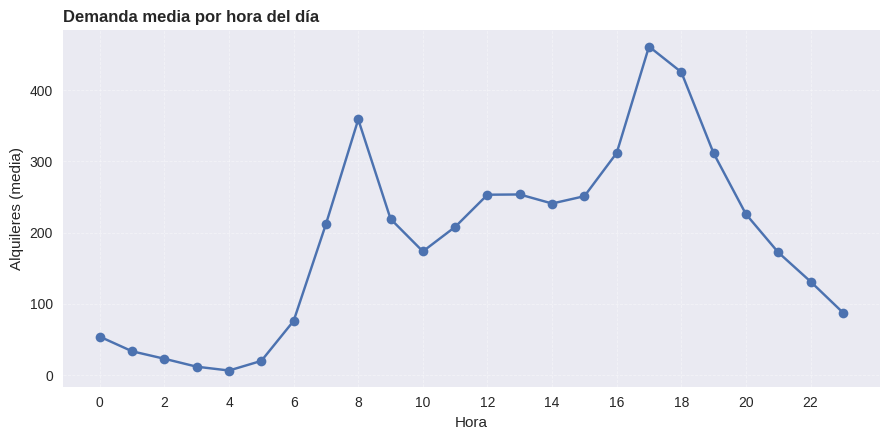

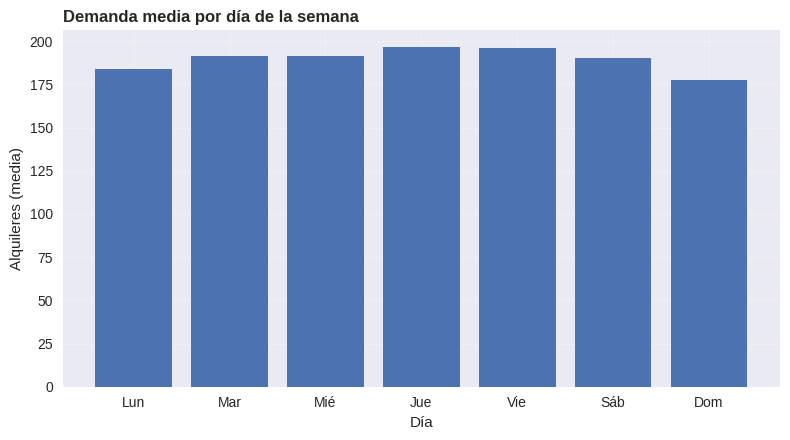

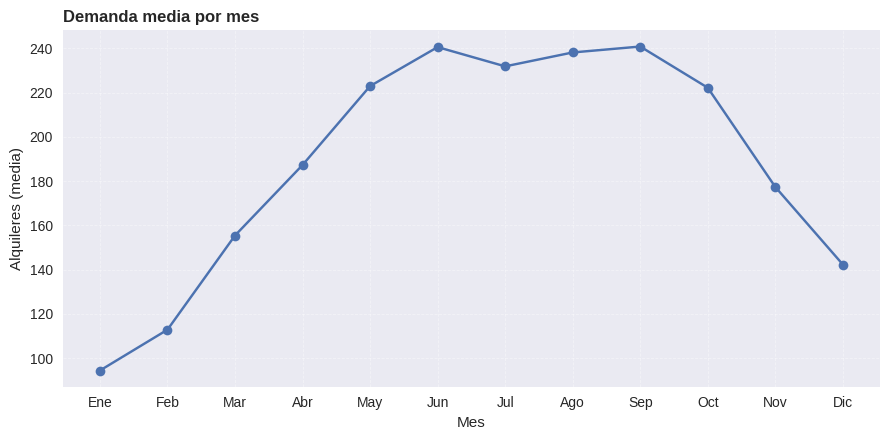

Gráficos mostrados y guardados en 'results/'.


In [36]:
# Distribuciones de demanda: hora, día de la semana y mes (se muestran y se guardan)
# Crear carpeta results si no existe (sin imports explícitos)
__import__('os').makedirs("results", exist_ok=True)

def _set_common(ax, title, xlabel, ylabel):
    ax.set_title(title, loc="left", fontsize=12, fontweight="bold")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.4)

# 1 Distribución por HORA
_hourly = (df_raw.groupby("hr", as_index=False)["number_of_rentals"]
           .mean().sort_values("hr"))
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(_hourly["hr"], _hourly["number_of_rentals"], marker="o")
ax.set_xticks(range(0, 24, 2))
_set_common(ax, "Demanda media por hora del día", "Hora", "Alquileres (media)")
fig.tight_layout()
fig.savefig("results/demanda_por_hora.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

# 2 Distribución por DÍA DE LA SEMANA
_weekday_order  = [0,1,2,3,4,5,6]
_weekday_labels = ["Lun","Mar","Mié","Jue","Vie","Sáb","Dom"]
_by_weekday = (df_raw.groupby("weekday", as_index=False)["number_of_rentals"]
               .mean().set_index("weekday").reindex(_weekday_order).reset_index())
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.bar(_weekday_labels, _by_weekday["number_of_rentals"])
_set_common(ax, "Demanda media por día de la semana", "Día", "Alquileres (media)")
fig.tight_layout()
fig.savefig("results/demanda_por_dia_semana.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

# 3 Distribución por MES
_month_order  = list(range(1, 13))
_month_labels = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]
_by_month = (df_raw.groupby("month", as_index=False)["number_of_rentals"]
             .mean().set_index("month").reindex(_month_order).reset_index())
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.plot(_by_month["month"], _by_month["number_of_rentals"], marker="o")
ax.set_xticks(_month_order)
ax.set_xticklabels(_month_labels)
_set_common(ax, "Demanda media por mes", "Mes", "Alquileres (media)")
fig.tight_layout()
fig.savefig("results/demanda_por_mes.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

print("Gráficos mostrados y guardados en 'results/'.")


# Interpretación de las distribuciones de demanda

### Distribución por hora
La demanda de bicicletas presenta un marcado patrón diario. Durante la madrugada (entre las 0:00 y las 5:00) el número medio de alquileres es muy reducido, con mínimos por debajo de 10 a las 4:00. A partir de las 6:00 la demanda comienza a incrementarse de forma significativa, alcanzando un primer pico en torno a las 8:00 con más de 350 alquileres, coincidiendo con los desplazamientos al trabajo o a centros educativos.  

Tras este pico matinal, la demanda desciende ligeramente hacia el mediodía, aunque se mantiene estable entre 200 y 250 alquileres por hora. Posteriormente, se observa un segundo pico más acusado entre las 17:00 y las 18:00 horas, superando los 450 alquileres en la franja de máxima demanda. A partir de las 20:00 la demanda decrece progresivamente hasta llegar de nuevo a niveles bajos durante la madrugada.  

Este comportamiento refleja claramente la influencia de los horarios laborales y escolares en el uso del sistema de bicicletas compartidas.

---

### Distribución por día de la semana
El análisis por día de la semana muestra un patrón relativamente estable de lunes a viernes, con una media cercana a los 190-196 alquileres por hora. El lunes presenta una demanda ligeramente inferior respecto al resto de días laborables, mientras que jueves y viernes son los días de mayor uso.  

Durante el fin de semana, la demanda disminuye: el sábado se sitúa en torno a los 190 alquileres por hora, mientras que el domingo es el día con menor actividad (177 alquileres por hora de media). Esto sugiere que el uso del sistema está más asociado a desplazamientos rutinarios (trabajo o estudio) que a actividades recreativas.

---

### Distribución por mes
La demanda presenta una clara estacionalidad. Los meses de invierno registran la menor actividad, especialmente enero (94 alquileres por hora) y febrero (112). A partir de marzo comienza un crecimiento sostenido hasta alcanzar el máximo en los meses de verano y principios de otoño, con valores que oscilan entre 230 y 241 alquileres por hora en junio, julio, agosto y septiembre.  

Posteriormente, a partir de octubre, la demanda desciende de nuevo, llegando a mínimos en diciembre (142). Este patrón estacional está fuertemente influenciado por las condiciones meteorológicas y climáticas, con un mayor uso del sistema en épocas de temperaturas suaves y menor presencia de precipitaciones.

---


# Seleccion de variables

## Selección de Features mediante Correlación

Para reducir la dimensionalidad y evitar problemas de multicolinealidad en nuestro modelo de Machine Learning, realizamos un análisis de correlación entre las variables independientes del dataset.

La **matriz de correlación** nos ayuda a identificar pares de variables altamente correlacionadas entre sí. Cuando dos variables aportan información casi idéntica (correlación > 0.70), es razonable eliminar una de ellas para simplificar el modelo, mejorar su interpretabilidad y evitar redundancia innecesaria.

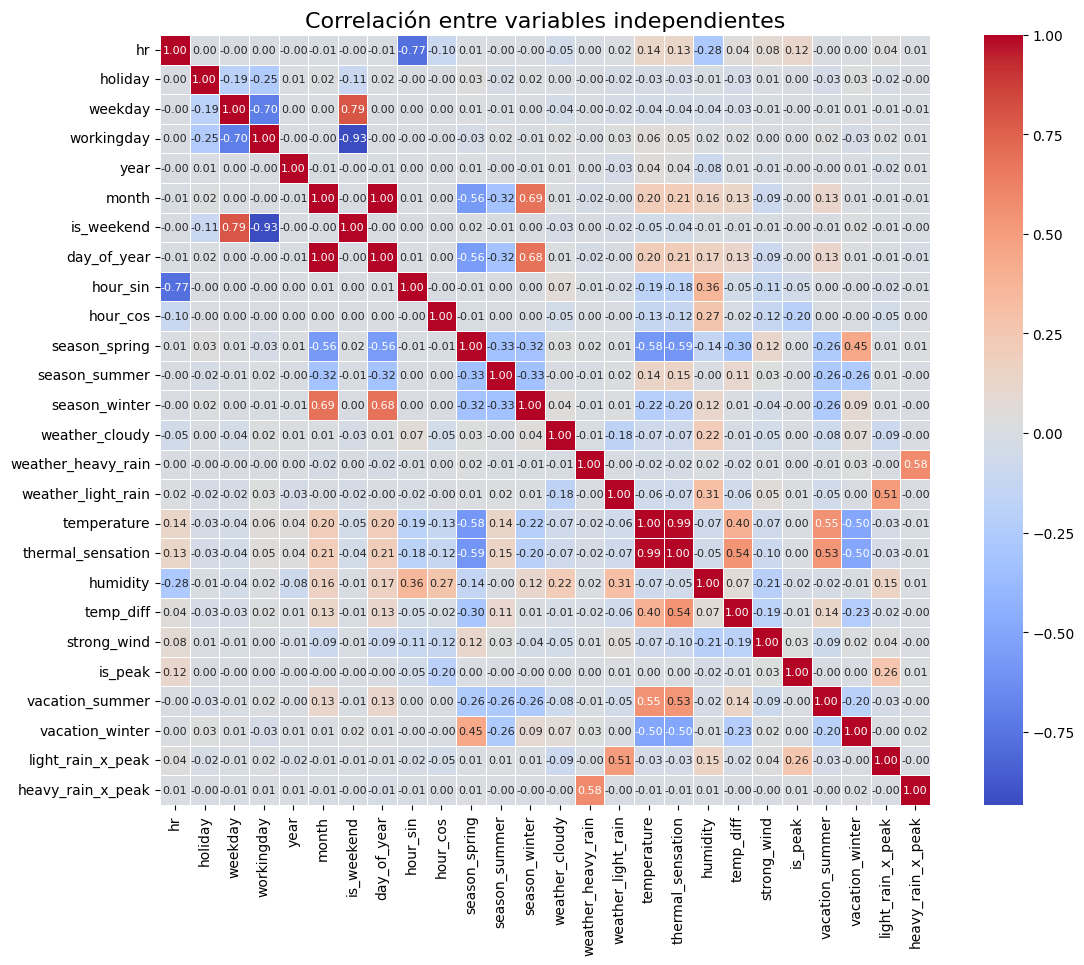

In [8]:
# Calcular matriz de correlación
corr_matrix = df.drop(columns='number_of_rentals').corr()

plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Correlación entre variables independientes", fontsize=16)
plt.show()



In [9]:
# Calcular matriz de correlación (sin variable objetivo)
corr_matrix = df.drop(columns='number_of_rentals').corr().abs()

# Obtener pares de columnas altamente correlacionadas (sin duplicados ni diagonales)
high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Filtrar pares con correlación mayor a 0.70
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlación'] > 0.70]

# Ordenar de mayor a menor
high_corr_pairs = high_corr_pairs.sort_values(by='Correlación', ascending=False)

# Mostrar resultados
print("PARES DE VARIABLES CON CORRELACIÓN > 0.70")
display(high_corr_pairs)


PARES DE VARIABLES CON CORRELACIÓN > 0.70


,Variable 1,Variable 2,Correlación
116,month,day_of_year,0.996493
280,temperature,thermal_sensation,0.987672
74,workingday,is_weekend,0.934105
52,weekday,is_weekend,0.791267
7,hr,hour_sin,0.774988
49,weekday,workingday,0.702419


In [10]:
# Variables a eliminar según el análisis de correlación y redundancia
features_to_drop = [
    'month',
    'thermal_sensation',
    'is_weekend',
    'hr',
]

# Eliminar las columnas si existen en el DataFrame
df.drop(columns=[col for col in features_to_drop if col in df.columns], inplace=True)

# Verificación
print("Variables eliminadas:", features_to_drop)
print("Dimensiones del DataFrame final:", df.shape)


Variables eliminadas: ['month', 'thermal_sensation', 'is_weekend', 'hr']
Dimensiones del DataFrame final: (17379, 23)


## Variables eliminadas por correlación

Las siguientes variables han sido eliminadas del dataset por considerarse redundantes o menos informativas dentro de pares altamente correlacionados:

- **`month`**: Tiene una correlación casi perfecta con `day_of_year` (0.996). Se elimina `month` y se conserva `day_of_year`, ya que este último tiene mayor granularidad temporal (1 a 365), lo que permite capturar mejor patrones estacionales y temporales finos.

- **`thermal_sensation`**: Altamente correlacionada con `temperature`. En su lugar, usamos la variable derivada `temp_diff`, que aporta más valor al representar la diferencia entre temperatura real y sensación térmica.

- **`is_weekend`**: Derivable directamente de `weekday`, y en parte cubierta por `workingday`. Eliminada para reducir redundancia.

- **`hr`**: Reemplazada por `hour_sin` y `hour_cos`, una codificación cíclica que representa mejor la naturaleza circular de las horas (por ejemplo, 23 y 0 están más cerca de lo que parecen en un formato lineal).

---

## Variables que se mantienen

Aunque algunas de estas variables tienen cierta correlación con otras, se han conservado por su utilidad práctica y capacidad de aportar valor distintivo al modelo:

- **`weekday`**: Representa el día de la semana (0=lunes, ..., 6=domingo). Puede capturar patrones distintos que `workingday` no refleja completamente.

- **`workingday`**: Variable importante que indica si un día es laboral (excluyendo fines de semana y festivos).

- **`temperature`**: Es la variable original que mide la temperatura real, directa y fácil de interpretar.

- **`temp_diff`**: Variable derivada que indica la diferencia entre la temperatura real y la sensación térmica. Añade una dimensión útil sobre las condiciones climáticas percibidas.

- **`day_of_year`**: Se mantiene por su mayor granularidad respecto a `month`, permitiendo detectar patrones finos a lo largo del año.

## Selección de Variables basada en Random Forest

Como paso de reducción de dimensionalidad, se entrenó un modelo de Random Forest sobre todos los datos con el objetivo de estimar la importancia relativa de cada variable predictora.

Las **importancias de las variables** indican cuánto contribuye cada una a la predicción final. A partir de este análisis se estableció un **umbral de corte de 0.009**: cualquier variable por debajo de este valor se considera poco informativa y se elimina para evitar ruido y sobreajuste.

Esto permitió reducir el número de variables manteniendo prácticamente todo el poder predictivo del dataset.


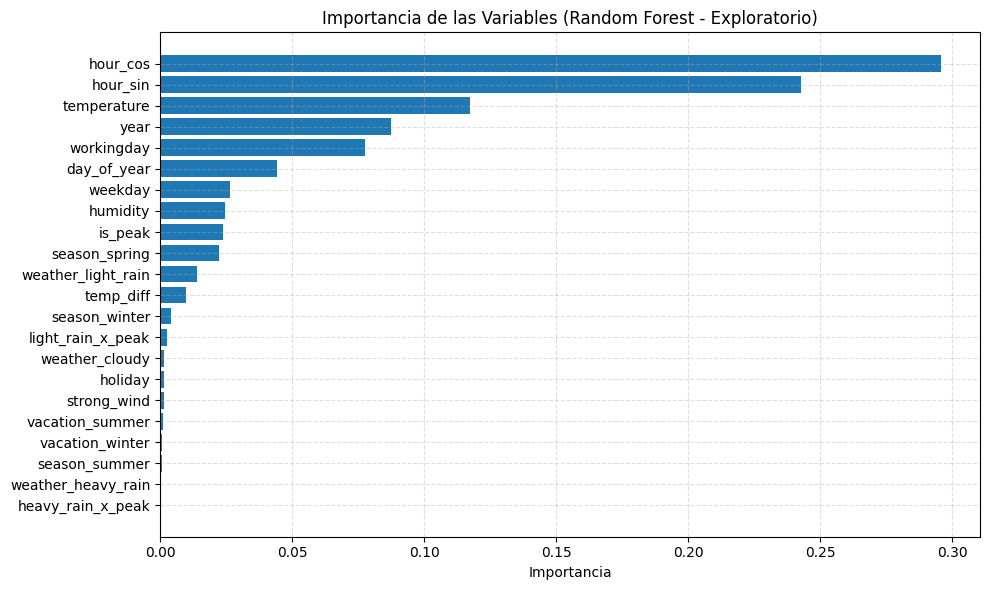

In [11]:
# 1. Separar variables predictoras y target
X = df.drop(columns=['number_of_rentals'])
y = df['number_of_rentals']

# 2. Entrenar modelo de Random Forest completo (con default params)
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# 3. Obtener importancia de las features
importances = model.feature_importances_
feature_names = X.columns

# 4. Crear DataFrame ordenado
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 5. Visualización
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importancia")
plt.title("Importancia de las Variables (Random Forest - Exploratorio)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [12]:
feature_importance_df.reset_index(drop=True)

,Feature,Importance
0,hour_cos,2.957458e-01
1,hour_sin,2.426072e-01
2,temperature,1.173842e-01
3,year,8.762874e-02
4,workingday,7.768743e-02
5,day_of_year,4.429970e-02
6,weekday,2.639530e-02
7,humidity,2.447843e-02
8,is_peak,2.383128e-02
9,season_spring,2.248282e-02


In [13]:
# Umbral mínimo de importancia
threshold = 0.009

# Obtener lista de variables a eliminar
features_to_drop = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()

# Eliminar esas columnas del DataFrame df
df.drop(columns=features_to_drop, inplace=True)

# Mostrar lista de columnas eliminadas
print("Variables eliminadas por baja importancia (< 0.009):")
print(features_to_drop)

Variables eliminadas por baja importancia (< 0.009):
['season_winter', 'light_rain_x_peak', 'weather_cloudy', 'holiday', 'strong_wind', 'vacation_summer', 'vacation_winter', 'season_summer', 'weather_heavy_rain', 'heavy_rain_x_peak']


## Variables eliminadas por baja importancia:
- `season_winter`
- `light_rain_x_peak`
- `weather_cloudy`
- `holiday`
- `strong_wind`
- `vacation_summer`
- `vacation_winter`
- `season_summer`
- `weather_heavy_rain`
- `heavy_rain_x_peak`

# División del conjunto de datos

Para evaluar correctamente el rendimiento del modelo de predicción de alquileres de bicicletas, se ha realizado una **división temporal** del conjunto de datos, respetando su orden cronológico. Esta estrategia es especialmente adecuada para datos con estructura temporal, ya que permite simular de forma realista un escenario de predicción futura.

En lugar de una partición aleatoria, se ha dividido el dataset de la siguiente manera:

- **Conjunto de entrenamiento (`train`)**: incluye todas las observaciones **anteriores al 1 de junio de 2012**.
- **Conjunto de test (`test`)**: incluye todas las observaciones **a partir del 1 de junio de 2012**, incluyendo ese día.

Esta partición evita la fuga de información desde el futuro hacia el pasado y permite medir el rendimiento del modelo sobre datos no vistos que representan periodos más recientes.

Dado que la columna `date` original fue eliminada en fases anteriores del preprocesamiento, se ha reconstruido utilizando las columnas `year` y `day_of_year`, generando una nueva columna de tipo fecha (`date`). A partir de ella, se ha creado una máscara lógica para seleccionar las observaciones correspondientes al periodo de test.

Una vez realizada la partición temporal, se separaron las variables predictoras (`X`) de la variable objetivo (`y`), eliminando la columna `date` reconstruida, ya que no se utilizará como input directo en el modelo.

Este procedimiento garantiza una evaluación más realista del comportamiento futuro del modelo y es especialmente recomendable en problemas de predicción temporal como el presente caso.


In [14]:
# 1. Reconstruir la columna 'date' a partir de 'year' y 'day_of_year'
df['date'] = pd.to_datetime(df['year'].astype(str), format='%Y') + pd.to_timedelta(df['day_of_year'] - 1, unit='D')

# 2. Crear condición para separar los datos: test desde el 1 de junio de 2012 en adelante
cutoff_date = pd.to_datetime('2012-06-01')
mask_test = df['date'] >= cutoff_date

# 3. Crear train y test
df_train = df[~mask_test].copy()
df_test = df[mask_test].copy()

# 4. Separar variables predictoras y target
X_train = df_train.drop(columns=['number_of_rentals', 'date'])
y_train = df_train['number_of_rentals']

X_test = df_test.drop(columns=['number_of_rentals', 'date'])
y_test = df_test['number_of_rentals']

# Verificar resultados
print("Tamaño conjunto de entrenamiento:", X_train.shape)
print("Tamaño conjunto de test:", X_test.shape)


Tamaño conjunto de entrenamiento: (12283, 12)
Tamaño conjunto de test: (5096, 12)


# Entrenamiento de modelos

Con el conjunto de datos ya preprocesado y dividido temporalmente, se llevó a cabo el entrenamiento de distintos modelos de **regresión** para predecir la variable `number_of_rentals`, que representa el número de bicicletas alquiladas en una hora determinada.

---

## Selección de modelos

Se han elegido modelos que cubren distintos enfoques de regresión: técnicas lineales, basadas en distancias, árboles de decisión y métodos avanzados de ensamblado.  
La selección final fue la siguiente:

- **Ridge**: regresión lineal con regularización L2.  
- **Lasso**: regresión lineal con regularización L1.  
- **ElasticNet**: combinación de L1 y L2, útil cuando hay muchas variables correlacionadas.  
- **KNN**: algoritmo basado en vecinos más cercanos, sensible a la escala de los datos.  
- **SVR (Support Vector Regression)**: método robusto para regresión, especialmente útil en presencia de ruido.  
- **Random Forest**: ensamblado basado en múltiples árboles con promedios para reducir la varianza.  
- **ExtraTrees**: variante más extrema de Random Forest con mayor aleatoriedad.  
- **XGBoost**: algoritmo de boosting altamente optimizado y eficiente.  
- **LightGBM**: alternativa de boosting más rápida y escalable que XGBoost.  
- **HistGradientBoostingRegressor**: implementación moderna de gradient boosting, eficiente y escalable, ideal para datasets grandes.

---

## Construcción de pipelines

Para garantizar un flujo de trabajo **limpio y reproducible**, los modelos que lo requerían (como regresiones lineales, SVR y KNN) se encapsularon en **pipelines** junto con un `StandardScaler`.  
Esto permite aplicar la estandarización como parte del proceso de entrenamiento y validación, evitando el *data leakage*.

---

## Búsqueda de hiperparámetros

Cada modelo fue ajustado utilizando **GridSearchCV**, realizando una búsqueda exhaustiva sobre una malla de hiperparámetros predefinidos.  
Se empleó **validación cruzada** con 5 particiones (`cv=5`) para estimaciones robustas del rendimiento y para evitar sobreajuste.

- **Métrica utilizada:** `neg_root_mean_squared_error` (RMSE negativo).  
- Posteriormente, el valor se convierte a RMSE positivo para evaluar los resultados finales.  
- Esta métrica penaliza más fuertemente los errores grandes, útil para minimizar desviaciones considerables.

---

## Entrenamiento y evaluación

Una vez definidos los pipelines y las mallas de hiperparámetros, cada modelo fue:

1. Entrenado sobre el conjunto de entrenamiento.  
2. Validado con **GridSearchCV**.  
3. Guardado el mejor estimador encontrado (`best_estimator_`).

---


In [15]:
# 1. Definir pipelines

ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", Lasso())
])

elastic_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("elastic", ElasticNet())
])

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

rf_pipeline = RandomForestRegressor(random_state=42)
xgb_pipeline = XGBRegressor(random_state=42)
lgbm_pipeline = LGBMRegressor(random_state=42)
et_pipeline = ExtraTreesRegressor(random_state=42)
histgb_pipeline = HistGradientBoostingRegressor(random_state=42)


In [16]:
# 2. Definir grids de hiperparámetros

grid_ridge = {
    'ridge__alpha': [0.1, 1, 10]
}

grid_lasso = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1]
}

grid_elastic = {
    'elastic__alpha': [0.01, 0.1, 1],
    'elastic__l1_ratio': [0.1, 0.5, 0.9]
}

grid_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

grid_svm = {
    'svr__C': [0.1, 1, 10],
    'svr__kernel': ['linear', 'rbf'],
    'svr__gamma': ['scale']
}

grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01]
}

grid_lgbm = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 10],
    'learning_rate': [0.1, 0.01]
}

grid_et = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_histgb = {
    'learning_rate': [0.1, 0.01],
    'max_iter': [100, 200],
    'max_depth': [None, 10]
}

In [17]:
# 3. Configurar GridSearchCV

gs_ridge = GridSearchCV(ridge_pipeline, grid_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_lasso = GridSearchCV(lasso_pipeline, grid_lasso, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_elastic = GridSearchCV(elastic_pipeline, grid_elastic, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_knn = GridSearchCV(knn_pipeline, grid_knn, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_svm = GridSearchCV(svm_pipeline, grid_svm, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_rf = GridSearchCV(rf_pipeline, grid_rf, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_xgb = GridSearchCV(xgb_pipeline, grid_xgb, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_lgbm = GridSearchCV(lgbm_pipeline, grid_lgbm, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_et = GridSearchCV(et_pipeline, grid_et, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs_histgb = GridSearchCV(histgb_pipeline, grid_histgb, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)


In [18]:
# 4. Diccionario de modelos (sin GradientBoosting clásico)

modelos = {
    "Ridge": gs_ridge,
    "Lasso": gs_lasso,
    "ElasticNet": gs_elastic,
    "KNN": gs_knn,
    "SVR": gs_svm,
    "Random Forest": gs_rf,
    "XGBoost": gs_xgb,
    "LightGBM": gs_lgbm,
    "ExtraTrees": gs_et,
    "HistGradientBoosting": gs_histgb
}

In [19]:
# 5. Entrenamiento de todos

resultados = {}
for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo.fit(X_train, y_train)
    resultados[nombre] = modelo


Entrenando modelo: Ridge
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Entrenando modelo: Lasso
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Entrenando modelo: ElasticNet
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Entrenando modelo: KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Entrenando modelo: SVR
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Entrenando modelo: Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Entrenando modelo: XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Entrenando modelo: LightGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data point

In [20]:
# Crear un DataFrame con los scores negativos de RMSE (los convertimos a positivos)
df_scores = pd.DataFrame({
    "Modelo": list(resultados.keys()),
    "RMSE CV": [-modelo.best_score_ for modelo in resultados.values()]
})

# Ordenar de mejor (menor RMSE) a peor
df_scores = df_scores.sort_values(by="RMSE CV", ascending=True).reset_index(drop=True)

# Estilo de tabla con pandas Styler
df_scores_styled = (
    df_scores.style
    .format({"RMSE CV": "{:.4f}"})
    .set_table_styles([
        {'selector': 'th', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('border', '1px solid black'), ('text-align', 'center')]},
        {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('margin', 'auto')]}
    ])
)

df_scores_styled

,Modelo,RMSE CV
0,XGBoost,62.1336
1,HistGradientBoosting,62.4299
2,LightGBM,63.7844
3,ExtraTrees,65.7714
4,Random Forest,72.7694
5,SVR,75.2560
6,KNN,83.0786
7,ElasticNet,95.9213
8,Ridge,96.0435
9,Lasso,96.0505


In [21]:
# Obtener el nombre del mejor modelo (menor RMSE CV)
mejor_modelo_nombre = df_scores.loc[df_scores["RMSE CV"].idxmin(), "Modelo"]
mejor_modelo = resultados[mejor_modelo_nombre]

# Guardar el mejor modelo ya entrenado
joblib.dump(mejor_modelo, f"{mejor_modelo_nombre}_mejor_modelo.pkl")

print(f"Modelo guardado: {mejor_modelo_nombre}")

Modelo guardado: XGBoost


# Evaluación final sobre el conjunto de test

Una vez entrenado y seleccionado el mejor modelo, se ha realizado su validación sobre un conjunto de **test independiente** para comprobar la capacidad de generalización.  
La evaluación incluye tanto métricas cuantitativas (MAE, RMSE, R², MSLE, error relativo medio) como representaciones gráficas (real vs predicho, residuos, distribución de errores y comparación ordenada).  

Este análisis conjunto permite valorar no solo la precisión global del modelo, sino también cómo se comporta en distintos niveles de demanda y si existen sesgos sistemáticos en las predicciones.


In [30]:
# 1) Estadísticos descriptivos de y_test
import numpy as np

y_test_array = np.asarray(y_test, dtype=float)

media_alquileres = y_test_array.mean()
varianza_alquileres = y_test_array.var(ddof=1)            # varianza muestral
desviacion_tipica_alquileres = y_test_array.std(ddof=1)   # desviación típica muestral

print(f"La media de bicicletas alquiladas por hora es: {media_alquileres:.2f}")
print(f"La varianza de bicicletas alquiladas por hora es: {varianza_alquileres:.2f}")
print(f"La desviación típica de bicicletas alquiladas por hora es: {desviacion_tipica_alquileres:.2f}")


La media de bicicletas alquiladas por hora es: 257.99
La varianza de bicicletas alquiladas por hora es: 48526.77
La desviación típica de bicicletas alquiladas por hora es: 220.29


## Estadísticos descriptivos del conjunto de test

El análisis descriptivo básico de la variable objetivo (número de bicicletas alquiladas por hora) muestra lo siguiente:

- **Media ≈ 258**: en promedio, se alquilan unas 258 bicicletas por hora.  
- **Varianza ≈ 48.527**: indica una alta dispersión en los valores de la demanda.  
- **Desviación típica ≈ 220**: en promedio, los valores de alquiler por hora se desvían unas 220 bicicletas respecto a la media.

Estos resultados reflejan que la demanda presenta una gran variabilidad. En determinadas horas (como las horas punta o durante condiciones meteorológicas favorables) se alcanzan valores muy superiores a la media, mientras que en otras franjas horarias (como la madrugada) los valores se reducen considerablemente. Este alto nivel de dispersión justifica la necesidad de modelos de predicción que sean capaces de capturar tanto los patrones de alta como de baja demanda.


In [31]:
# 2) Predicción y métricas en test
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
)
import numpy as np

# Predicciones
y_pred = mejor_modelo.predict(X_test)

# Conversión/seguridad
y_test_np = np.asarray(y_test, dtype=float)

# Métricas principales
mae  = mean_absolute_error(y_test_np, y_pred)
mse  = mean_squared_error(y_test_np, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test_np, y_pred)

# Métricas relativas más estables que MAPE en presencia de valores bajos
mae_relative = mae / y_test_np.mean()
# MSLE (robustez en bajas demandas). Clip a no-negativos por seguridad
y_pred_nonneg = np.clip(y_pred, 0, None)
y_test_nonneg = np.clip(y_test_np, 0, None)
msle = mean_squared_log_error(y_test_nonneg, y_pred_nonneg)

# Medias
media_real      = y_test_np.mean()
media_predicha  = np.asarray(y_pred).mean()

# Guardar un diccionario por si quieres tabular o exportar
metrics_dict = {
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2,
    "MSLE": msle,
    "MAE_relativo": mae_relative,
    "media_real": media_real,
    "media_predicha": media_predicha,
}

# Mostrar breve
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")
print(f"MSLE: {msle:.4f}")
print(f"MAE / media (error relativo medio): {mae_relative:.2%}")


MAE : 45.80
RMSE: 65.67
R²  : 0.9111
MSLE: 0.3828
MAE / media (error relativo medio): 17.75%


### Métricas de evaluación en el conjunto de test

Los resultados obtenidos permiten valorar la capacidad predictiva del modelo sobre datos no vistos:

- **MAE ≈ 45.8**: el error absoluto medio equivale a unas 46 bicicletas por hora. Dado que la media de la serie es de aproximadamente 258, el error representa un **17,8% de la demanda promedio**.  
- **RMSE ≈ 65.7**: el error cuadrático medio, que penaliza más los errores grandes, es algo mayor que el MAE. Esto indica que existen algunos picos de error en horas concretas (por ejemplo, en horas punta o en situaciones meteorológicas extremas), aunque no son dominantes.  
- **R² ≈ 0.91**: el modelo explica más del 90% de la variabilidad de la demanda horaria, lo que evidencia un ajuste sólido a los patrones subyacentes.  
- **MSLE ≈ 0.38**: los errores relativos, evaluados en escala logarítmica, se mantienen controlados, especialmente en aquellas horas con baja demanda, donde los errores absolutos pequeños podrían amplificarse de manera desproporcionada.

El **MAE relativo** es la métrica más útil aquí: comunica de forma sencilla y comparable la magnitud real del error en relación con la escala del problema. El modelo falla un **17,8%** de las veces


En conjunto, el modelo presenta un buen equilibrio: consigue explicar la mayor parte de la variación en los datos y mantiene un error moderado en términos relativos, lo que lo hace útil para estimar la demanda de bicicletas a nivel operativo.


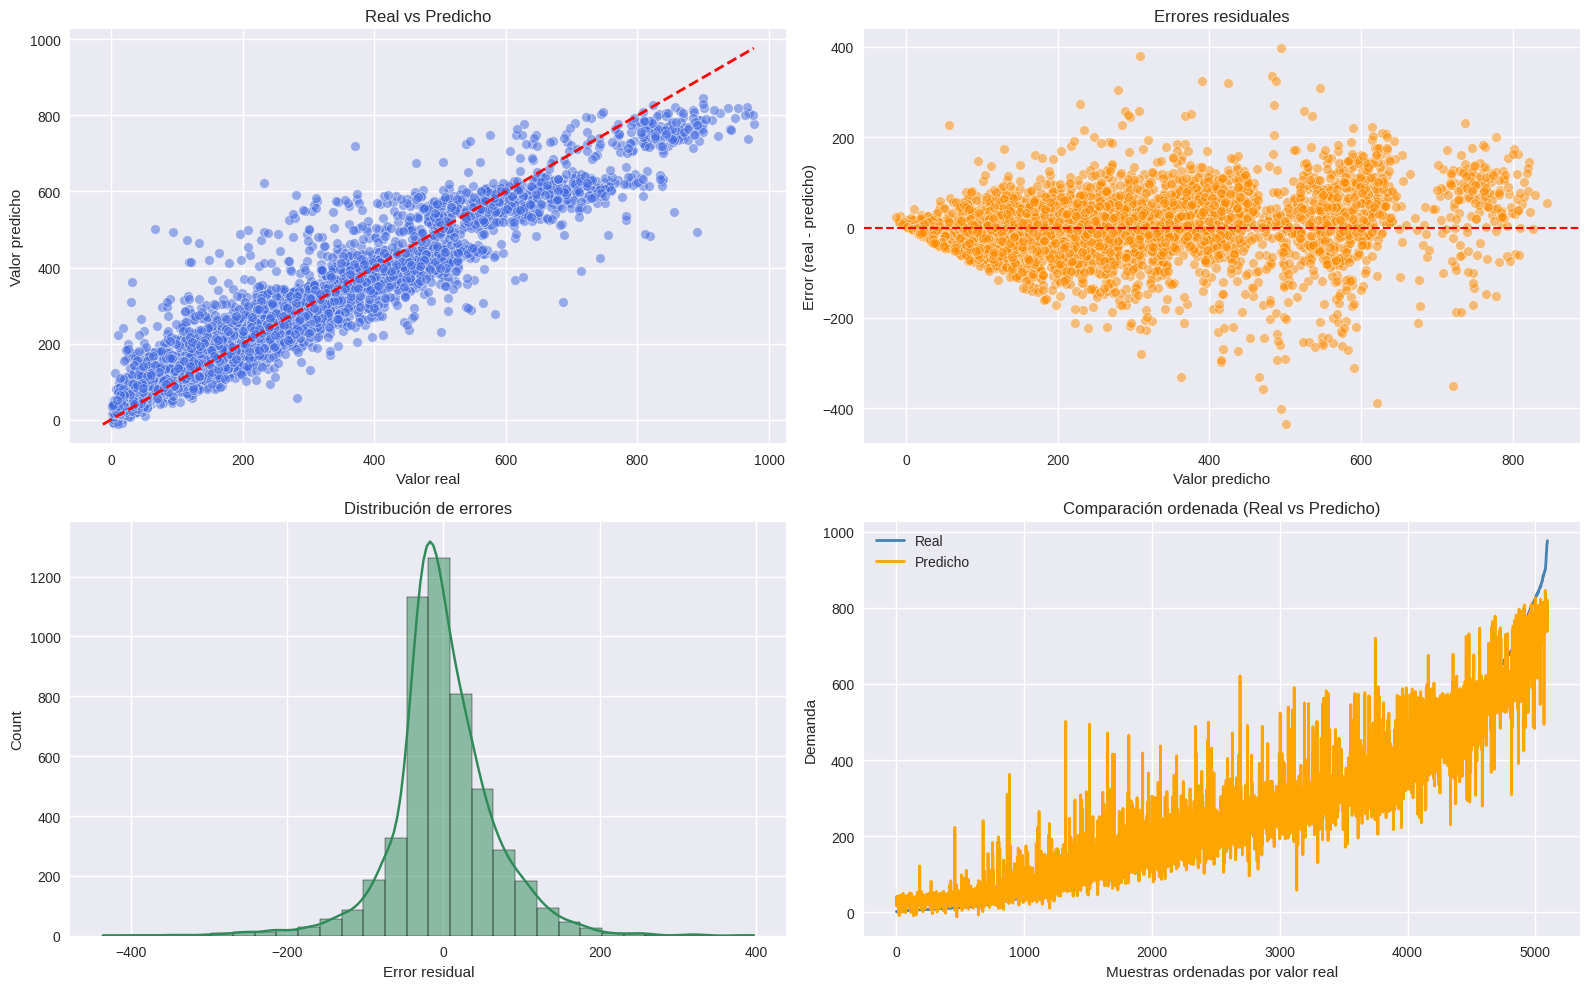

Gráfico de desempeño guardado en 'results/evaluacion_modelo.png'


In [38]:
# 3) Visualizaciones de desempeño (mostrar y guardar en 'results')
plt.style.use("seaborn-v0_8")

# Asegurar carpeta results
__import__('os').makedirs("results", exist_ok=True)

errores = y_test_np - y_pred

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1 Real vs Predicho
sns.scatterplot(x=y_test_np, y=y_pred, alpha=0.5, ax=axes[0,0],
                color="royalblue", edgecolor="white")
min_xy = min(y_test_np.min(), y_pred.min())
max_xy = max(y_test_np.max(), y_pred.max())
axes[0,0].plot([min_xy, max_xy], [min_xy, max_xy], "r--", lw=2)
axes[0,0].set_title("Real vs Predicho")
axes[0,0].set_xlabel("Valor real")
axes[0,0].set_ylabel("Valor predicho")

# 2 Residuos vs Predicho
sns.scatterplot(x=y_pred, y=errores, alpha=0.5, ax=axes[0,1],
                color="darkorange", edgecolor="white")
axes[0,1].axhline(0, color="red", linestyle="--", lw=1.5)
axes[0,1].set_title("Errores residuales")
axes[0,1].set_xlabel("Valor predicho")
axes[0,1].set_ylabel("Error (real - predicho)")

# 3 Distribución de errores
sns.histplot(errores, kde=True, ax=axes[1,0], color="seagreen", bins=30)
axes[1,0].set_title("Distribución de errores")
axes[1,0].set_xlabel("Error residual")

# 4 Curvas ordenadas por valor real
orden = np.argsort(y_test_np)
axes[1,1].plot(y_test_np[orden], label="Real", color="steelblue", lw=2)
axes[1,1].plot(np.asarray(y_pred)[orden], label="Predicho", color="orange", lw=2)
axes[1,1].set_title("Comparación ordenada (Real vs Predicho)")
axes[1,1].set_xlabel("Muestras ordenadas por valor real")
axes[1,1].set_ylabel("Demanda")
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Guardar figura en results
fig.savefig("results/evaluacion_modelo.png", dpi=300, bbox_inches="tight")
plt.close(fig)

print("Gráfico de desempeño guardado en 'results/evaluacion_modelo.png'")


## Interpretación de los gráficos de evaluación

1. **Real vs Predicho**  
   Los puntos aparecen ligeramente por debajo de la línea diagonal, lo que indica que el modelo tiende a **infrapredecir** la demanda en distintos niveles.

2. **Errores residuales**  
   Los residuos se concentran cerca de 0 en valores bajos de demanda, pero conforme la demanda aumenta los errores se expanden. Esto sugiere que el modelo es menos preciso en escenarios de alta demanda.

3. **Distribución de los errores**  
   La forma aproximadamente normal y centrada en 0 indica que los errores se reparten de manera simétrica, sin sesgo claro hacia la sobre o infrapredicción.

4. **Comparación ordenada**  
   Las curvas de valores reales y predichos siguen una tendencia similar, aunque con oscilaciones. Esto refleja que el modelo captura la forma general de la distribución de la demanda, pero no ajusta con exactitud cada punto.
